In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Importing the Dataset:

In [2]:
# Read file with stock prices.
df_stock_prices = pd.read_csv(r"C:\Users\IRLXB03\Downloads\bloomberg_data_DL.csv")

# Drop rows with any NaN values
df_stock_prices = df_stock_prices.dropna()

# Rename columns
df_stock_prices = df_stock_prices.rename(columns={
    'AGG US Equity': 'bond_price',
    'VTI US Equity': 'stock_price',
    'DBC US Equity': 'commodity_price',
    'VIX Index': 'volatility_price',
    df_stock_prices.columns[0]: 'date'   # rename first col
})

# Convert to numeric (in case of bad values -> NaN) 
cols = ['stock_price', 'bond_price', 'commodity_price', 'volatility_price']
df_stock_prices[cols] = df_stock_prices[cols].apply(pd.to_numeric, errors='coerce')

# Normalize prices using the initial price:
df_stock_prices[cols] = df_stock_prices[cols] / df_stock_prices[cols].iloc[0]

# Convert date column
df_stock_prices['date'] = pd.to_datetime(df_stock_prices['date'])

# Create columns with returns:
for col in cols:
    # delete _price suffix from column name
    col_name = f'{col}'.replace('_price', '_return')
    df_stock_prices[col_name] = df_stock_prices[col].pct_change()

# Drop first row (NaN values in returns)
df_stock_prices = df_stock_prices.dropna().reset_index(drop=True)

# Define max and min dates
max_date = df_stock_prices['date'].max()
min_date = df_stock_prices['date'].min()

# Choose feature columns (prices + returns)
price_cols = ['stock_price', 'bond_price', 'commodity_price', 'volatility_price']
return_cols = ['stock_return', 'bond_return', 'commodity_return', 'volatility_return']
feature_cols = price_cols + return_cols

# Define split dates to match those ones in the paper:
train_end   = pd.Timestamp("2010-12-31")
val_end     = pd.Timestamp("2011-01-01")
test_end    = pd.Timestamp("2020-04-30")

# Training set: 2005-01-01 to 2010-12-31
df_train = df_stock_prices[df_stock_prices['date'] <= train_end].reset_index(drop=True)

# Validation set: 2011-01-01 to 2015-12-31
df_val   = df_stock_prices[(df_stock_prices['date'] > train_end) &
                           (df_stock_prices['date'] <= val_end)].reset_index(drop=True)

# Test set: 2016-01-01 to 2020-12-31
df_test  = df_stock_prices[(df_stock_prices['date'] > val_end) &
                           (df_stock_prices['date'] <= test_end)].reset_index(drop=True)


In [3]:
df_train

,date,stock_price,bond_price,commodity_price,volatility_price,stock_return,bond_return,commodity_return,volatility_return
0,2006-02-06,1.002380,0.999801,0.987758,1.006173,0.002380,-0.000199,-0.012242,0.006173
1,2006-02-07,0.992622,0.999102,0.959184,1.048611,-0.009735,-0.000699,-0.028928,0.042178
2,2006-02-08,0.999762,0.998604,0.955104,0.989969,0.007193,-0.000498,-0.004253,-0.055923
3,2006-02-09,0.997858,0.999202,0.964080,1.012346,-0.001904,0.000599,0.009397,0.022603
4,2006-02-10,0.999905,0.997107,0.946528,0.993056,0.002051,-0.002097,-0.018206,-0.019055
...,...,...,...,...,...,...,...,...,...
1231,2010-12-27,1.137038,1.302688,1.178297,1.363426,0.000616,0.002848,-0.001844,0.072860
1232,2010-12-28,1.138090,1.295065,1.190923,1.351852,0.000925,-0.005852,0.010715,-0.008489
1233,2010-12-29,1.139842,1.304221,1.191357,1.333333,0.001540,0.007070,0.000364,-0.013699
1234,2010-12-30,1.138439,1.303231,1.176992,1.351852,-0.001231,-0.000759,-0.012057,0.013889


In [4]:
df_test

,date,stock_price,bond_price,commodity_price,volatility_price,stock_return,bond_return,commodity_return,volatility_return
0,2011-01-03,1.149657,1.307067,1.204416,1.358796,0.010320,-0.001134,0.004357,-0.007887
1,2011-01-04,1.147377,1.307438,1.188308,1.341049,-0.001983,0.000284,-0.013374,-0.013061
2,2011-01-05,1.153687,1.301127,1.200934,1.313272,0.005500,-0.004827,0.010625,-0.020713
3,2011-01-06,1.151058,1.301374,1.184827,1.342593,-0.002279,0.000190,-0.013412,0.022327
4,2011-01-07,1.148429,1.305582,1.180474,1.322531,-0.002284,0.003234,-0.003674,-0.014943
...,...,...,...,...,...,...,...,...,...
2342,2020-04-24,2.970705,1.847190,0.479333,2.772377,0.014905,-0.000511,-0.012923,-0.131706
2343,2020-04-27,3.023354,1.838690,0.470373,2.568673,0.017723,-0.004601,-0.018693,-0.073476
2344,2020-04-28,3.013915,1.845931,0.470821,2.590278,-0.003122,0.003938,0.000953,0.008411
2345,2020-04-29,3.099284,1.847190,0.479333,2.409722,0.028325,0.000682,0.018079,-0.069705


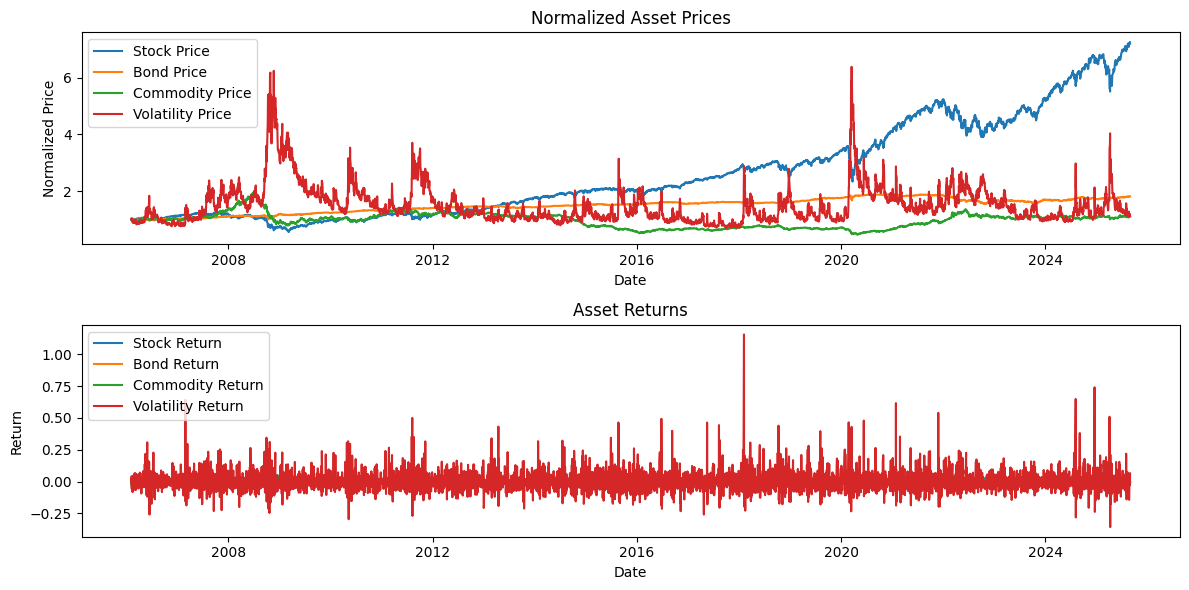

In [5]:
# Plot stock prices and returns
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df_stock_prices['date'], df_stock_prices['stock_price'], label='Stock Price')
plt.plot(df_stock_prices['date'], df_stock_prices['bond_price'], label='Bond Price')
plt.plot(df_stock_prices['date'], df_stock_prices['commodity_price'], label='Commodity Price')
plt.plot(df_stock_prices['date'], df_stock_prices['volatility_price'], label='Volatility Price')
plt.title('Normalized Asset Prices')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(df_stock_prices['date'], df_stock_prices['stock_return'], label='Stock Return')
plt.plot(df_stock_prices['date'], df_stock_prices['bond_return'], label='Bond Return')
plt.plot(df_stock_prices['date'], df_stock_prices['commodity_return'], label='Commodity Return')
plt.plot(df_stock_prices['date'], df_stock_prices['volatility_return'], label='Volatility Return')
plt.title('Asset Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.tight_layout()
plt.show()


#### Constructing the dataset:

In [6]:
# Hyperparameters:

seq_len = 50                        # lookback window
batch_size = 64                     # batch size for DataLoader
num_assets = len(return_cols)       # number of assets to allocate to
input_dim = len(feature_cols)       # number of features per asset
hidden_size = 64                    # LSTM hidden size
num_epochs = 10                     # number of training epochs

In [7]:
df_train[-50:]

,date,stock_price,bond_price,commodity_price,volatility_price,stock_return,bond_return,commodity_return,volatility_return
1186,2010-10-21,1.052719,1.327336,1.076010,1.486883,0.001659,-0.001565,-0.012384,-0.026276
1187,2010-10-22,1.055856,1.327949,1.084930,1.449074,0.002980,0.000462,0.008290,-0.025428
1188,2010-10-25,1.059342,1.328071,1.090807,1.531636,0.003302,0.000092,0.005417,0.056976
1189,2010-10-26,1.059168,1.325010,1.096465,1.560185,-0.000165,-0.002305,0.005187,0.018640
1190,2010-10-27,1.057076,1.322441,1.092984,1.597994,-0.001975,-0.001939,-0.003175,0.024233
1191,2010-10-28,1.057076,1.325746,1.098642,1.611111,0.000000,0.002499,0.005177,0.008209
1192,2010-10-29,1.058470,1.328560,1.096032,1.635802,0.001319,0.002123,-0.002376,0.015326
1193,2010-11-01,1.058644,1.328015,1.102995,1.684414,0.000165,-0.000410,0.006353,0.029717
1194,2010-11-02,1.067013,1.330346,1.113006,1.664352,0.007905,0.001755,0.009076,-0.011910
1195,2010-11-03,1.071370,1.330101,1.118231,1.509259,0.004083,-0.000184,0.004694,-0.093185


In [8]:
def make_xy(df, seq_len, feature_cols, return_cols):
    X, Y = [], []
    for t in range(seq_len, len(df)):
        # Features: last seq_len rows. Note: iloc[t-seq_len:t] includes [prices,returns] at time t-1.
        X.append(df[feature_cols].iloc[t-seq_len:t].values)
        # Label: next-day returns. Note: iloc[t] includes [returns] at time t.
        Y.append(df[return_cols].iloc[t].values)
    return np.array(X), np.array(Y)

X_train, Y_train = make_xy(df_train, seq_len, feature_cols=feature_cols, return_cols=return_cols)
X_val,   Y_val   = make_xy(df_val,   seq_len, feature_cols=feature_cols, return_cols=return_cols)
X_test,  Y_test  = make_xy(df_test,  seq_len, feature_cols=feature_cols, return_cols=return_cols)


In [9]:
# Convert numpy arrays to torch tensors:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
Y_val_t   = torch.tensor(Y_val,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test,  dtype=torch.float32)

# Create TensorDatasets:
train_ds = TensorDataset(X_train_t, Y_train_t)
val_ds   = TensorDataset(X_val_t,   Y_val_t)
test_ds  = TensorDataset(X_test_t,  Y_test_t)

# DataLoader with batching and shuffling
train_loader = DataLoader(train_ds, batch_size=26, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=26, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=26, shuffle=False, drop_last=False)


#### Define the LSTM → Dense → Softmax model

In [10]:
class PortfolioNet(nn.Module):
    def __init__(self, input_dim, hidden_size, num_assets):
        """
        input_dim   = number of features at each time step (e.g. 8: 4 prices + 4 returns)
        hidden_size = number of hidden units inside the LSTM (e.g. 64)
        num_assets  = number of portfolio weights we want as output (e.g. 4 assets)
        """
        super().__init__()   # initialize the parent nn.Module class

        # Define an LSTM layer
        # - batch_first=True means input shape is [batch, seq_len, input_dim]
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_size,
                            batch_first=True)

        # Define a fully connected (dense) layer
        # Maps from the hidden_size (e.g. 64) down to the number of assets (e.g. 4)
        self.fc = nn.Linear(hidden_size, num_assets)

    def forward(self, x):
        """
        Forward pass: defines how input data flows through the network

        x: [batch, seq_len, input_dim]
        Example: if batch_size=32, seq_len=50, input_dim=8 → shape [32, 50, 8]
        """
        # Pass the input sequence through the LSTM
        _, (h_n, _) = self.lstm(x)

        # lstm_out: [batch, seq_len, hidden_size]
        # h_n: is the final hidden state, shape [1, batch_size, hidden_size]

        # Picks the hidden state from the last layer, last time step 
        h_last = h_n[-1] # Shape becomes [batch, hidden_size]

        # Pass the last hidden state through the fully connected layer
        logits = self.fc(h_last)   #  One logit (raw score) [batch, hidden_size]→[batch, num_assets]

        # Apply softmax so that the outputs become portfolio weights:
        # - Each weight is >= 0
        # - All weights sum to 1
        weights = F.softmax(logits, dim=-1) # shape: [batch, num_assets]

        return weights

#### Custom sharpe ratio loss:

In [11]:
def sharpe_loss_batch(weights, next_day_returns):
    """
    weights: [batch, num_assets]
        - portfolio weights predicted by the model for each example in the batch
        - each row sums to 1 (because of softmax)
        - Example (batch=3, num_assets=4):
          [[0.2, 0.3, 0.1, 0.4],
           [0.1, 0.5, 0.2, 0.2],
           [0.25, 0.25, 0.25, 0.25]]

    next_day_returns: [batch, num_assets]
        - actual realised asset returns for the next day, one row per example
        - Example (same batch=3, num_assets=4):
          [[ 0.01, -0.005, 0.002, 0.003],
           [-0.002, 0.004, 0.001, -0.001],
           [ 0.010, 0.012, -0.003, 0.005]]
    """
    port_rets = (weights * next_day_returns).sum(dim=1)  
    mean_R = port_rets.mean()                            
    std_R = port_rets.std(unbiased=False) + 1e-8         
    sharpe = mean_R / std_R                             
    return -sharpe

#### Training loop

In [12]:
# Initialize model and optimizer
model = PortfolioNet(input_dim=input_dim,
                     hidden_size=hidden_size,
                     num_assets=num_assets)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
train_history, val_history = [], []

num_epochs = 100

for epoch in range(num_epochs):
    # -------------------
    # Training
    # -------------------
    model.train()
    train_losses = []
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        weights = model(X_batch)
        loss = sharpe_loss_batch(weights, Y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    train_history.append(-avg_train_loss)   # store Sharpe, not loss

    # -------------------
    # Validation
    # -------------------
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            weights = model(X_batch)
            val_loss = sharpe_loss_batch(weights, Y_batch)
            val_losses.append(val_loss.item())

    avg_val_loss = np.mean(val_losses)
    val_history.append(-avg_val_loss)       # store Sharpe

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Sharpe={-avg_train_loss:.4f} | Val Sharpe={-avg_val_loss:.4f}")

c:\Users\IRLXB03\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\IRLXB03\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 1/100 | Train Sharpe=0.0501 | Val Sharpe=nan
Epoch 2/100 | Train Sharpe=0.0586 | Val Sharpe=nan
Epoch 3/100 | Train Sharpe=0.0963 | Val Sharpe=nan
Epoch 4/100 | Train Sharpe=0.1149 | Val Sharpe=nan
Epoch 5/100 | Train Sharpe=0.1163 | Val Sharpe=nan
Epoch 6/100 | Train Sharpe=0.1309 | Val Sharpe=nan
Epoch 7/100 | Train Sharpe=0.1156 | Val Sharpe=nan
Epoch 8/100 | Train Sharpe=0.1407 | Val Sharpe=nan
Epoch 9/100 | Train Sharpe=0.1368 | Val Sharpe=nan
Epoch 10/100 | Train Sharpe=0.1299 | Val Sharpe=nan
Epoch 11/100 | Train Sharpe=0.1498 | Val Sharpe=nan
Epoch 12/100 | Train Sharpe=0.1339 | Val Sharpe=nan
Epoch 13/100 | Train Sharpe=0.1554 | Val Sharpe=nan
Epoch 14/100 | Train Sharpe=0.1280 | Val Sharpe=nan
Epoch 15/100 | Train Sharpe=0.1447 | Val Sharpe=nan
Epoch 16/100 | Train Sharpe=0.1307 | Val Sharpe=nan
Epoch 17/100 | Train Sharpe=0.1579 | Val Sharpe=nan
Epoch 18/100 | Train Sharpe=0.1582 | Val Sharpe=nan
Epoch 19/100 | Train Sharpe=0.1475 | Val Sharpe=nan
Epoch 20/100 | Train 

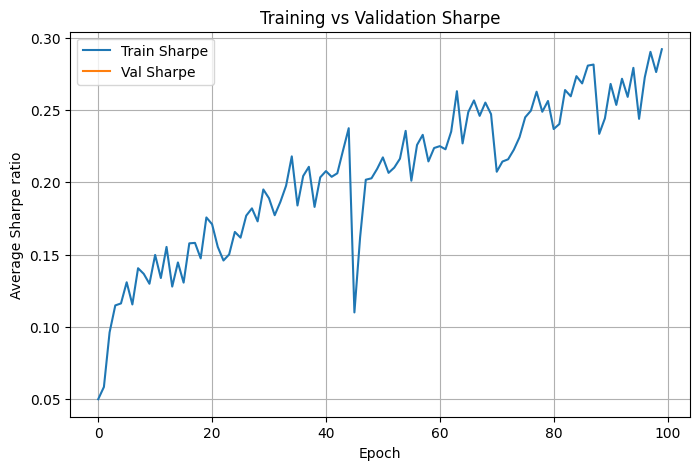

In [14]:
plt.figure(figsize=(8,5))
plt.plot(train_history, label="Train Sharpe")
plt.plot(val_history, label="Val Sharpe")
plt.xlabel("Epoch")
plt.ylabel("Average Sharpe ratio")
plt.title("Training vs Validation Sharpe")
plt.legend()
plt.grid(True)
plt.show()


In [85]:
# put model in eval mode
model.eval()

with torch.no_grad():

    # Predict portfolio weights
    weights_test = model(X_test_t)        # shape [N, num_assets]
    # Compute returns:
    test_returns = np.log(((1+Y_test_t) * weights_test).sum(dim=1))  # shape [N]
    # Cumulative returns of the portfolio:
    cum_returns = np.cumsum(test_returns.numpy())  # shape [N]
    # sharpe ratio:
    sharpe_ratio = ((Y_test_t) * weights_test).sum(dim=1).mean() / (((Y_test_t) * weights_test).sum(dim=1).std(unbiased=False) + 1e-8)

# Construct baseline allocations (equal weights)
weights_allocation_1 = [0.25, 0.25, 0.25, 0.25]  # equal weights
weights_allocation_2 = [0.50, 0.10, 0.20, 0.20]  # 50% stocks, 10% bonds, 20% commodities, 20% volatility
weights_allocation_3 = [0.10, 0.50, 0.20, 0.20]  # 10% stocks, 50% bonds, 20% commodities, 20% volatility
weights_allocation_4 = [0.40, 0.40, 0.10, 0.10]  # 40% stocks, 10% bonds, 10% commodities, 40% volatility

# Compute returns for baseline allocations
class_returns_1 = np.log(((1+Y_test_t) * torch.tensor(weights_allocation_1)).sum(dim=1)).numpy()
class_returns_2 = np.log(((1+Y_test_t) * torch.tensor(weights_allocation_2)).sum(dim=1)).numpy()
class_returns_3 = np.log(((1+Y_test_t) * torch.tensor(weights_allocation_3)).sum(dim=1)).numpy()
class_returns_4 = np.log(((1+Y_test_t) * torch.tensor(weights_allocation_4)).sum(dim=1)).numpy()

# Cumulative returns for baseline allocations
cum_class_returns_1 = np.cumsum(class_returns_1)
cum_class_returns_2 = np.cumsum(class_returns_2)
cum_class_returns_3 = np.cumsum(class_returns_3)
cum_class_returns_4 = np.cumsum(class_returns_4)

# Sharpe ratios for baseline allocations
sharpe_ratio_1 = ((Y_test_t) * torch.tensor(weights_allocation_1)).sum(dim=1).mean() / (((Y_test_t) * torch.tensor(weights_allocation_1)).sum(dim=1).std(unbiased=False) + 1e-8)
sharpe_ratio_2 = ((Y_test_t) * torch.tensor(weights_allocation_2)).sum(dim=1).mean() / (((Y_test_t) * torch.tensor(weights_allocation_2)).sum(dim=1).std(unbiased=False) + 1e-8)
sharpe_ratio_3 = ((Y_test_t) * torch.tensor(weights_allocation_3)).sum(dim=1).mean() / (((Y_test_t) * torch.tensor(weights_allocation_3)).sum(dim=1).std(unbiased=False) + 1e-8)
sharpe_ratio_4 = ((Y_test_t) * torch.tensor(weights_allocation_4)).sum(dim=1).mean() / (((Y_test_t) * torch.tensor(weights_allocation_4)).sum(dim=1).std(unbiased=False) + 1e-8)

In [87]:
sharpe_ratio_1, sharpe_ratio_2, sharpe_ratio_3, sharpe_ratio_4, sharpe_ratio

(tensor(0.0498),
 tensor(0.0668),
 tensor(0.0469),
 tensor(0.0916),
 tensor(0.1393))

In [76]:
print(((1+Y_test_t) * weights_test).numpy().std())
print(((1+Y_test_t).numpy() * weights_allocation_1).std())


0.27139375
0.010828479935195423


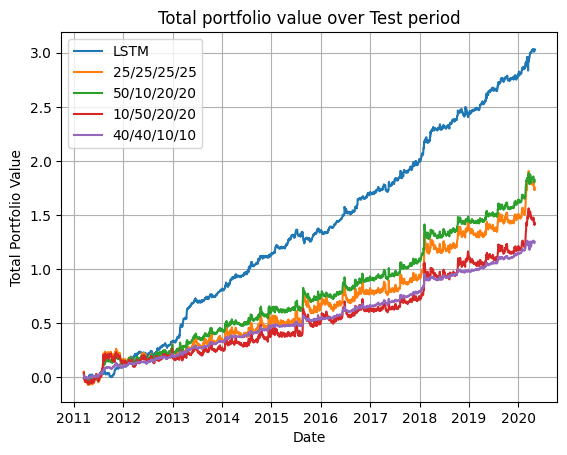

In [61]:
plt.plot(df_test['date'][seq_len:], cum_returns, label='LSTM')
plt.plot(df_test['date'][seq_len:], cum_class_returns_1, label='25/25/25/25')
plt.plot(df_test['date'][seq_len:], cum_class_returns_2, label='50/10/20/20')
plt.plot(df_test['date'][seq_len:], cum_class_returns_3, label='10/50/20/20')
plt.plot(df_test['date'][seq_len:], cum_class_returns_4, label='40/40/10/10')
plt.xlabel("Date")
plt.ylabel("Total Portfolio Value")
plt.title("Total portfolio value over Test period")
plt.legend()
plt.grid(True)
plt.show()
